# Just one (long) exercise: TDC signals analysis

### Description
This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC), implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of:
- a flag that specifies the type of message ('HEAD', which in this case is always 1),
- two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL')
- the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). 

    The triplet ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS') is a format for the time information analogous to ('hours', 'minutes', 'seconds'):
    - Each TDC count corresponds to 25/30 ns (**/ means division**),
    - Each BX_COUNTER corresponds to 25 ns,
    -  the ORBIT_CNT is increased every 'x' BX_COUNTER (with the value of x to be found)
    
This allows to store the time in a similar way to hours, minutes and seconds.

### Requests

- 1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

- 2\. Find out the number of BX in a ORBIT (the value 'x').

- 3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

- 4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

- 5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

- 6\. Create a new DataFrame that contains only the rows with HEAD=1.

- 7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

- 8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

- 9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

### Solution

#### 1\.

In [8]:
# -L option: follow the redirection link to the actual file
#!curl -L -O  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
filename = "data_000637.txt"
# inspect how many rows are there in the file

with open(filename, mode= 'r', ) as f:
    reader = csv.reader(f, delimiter=',')  # Specify ',' as the delimiter
    # print first 5 row to ensure everything is ok
    for i, row in enumerate(reader):
        print(row)
        if i == 5:
            break
    # now count the rows
    nrows = sum(1 for _ in reader)

f.close()
print(f"number of rows in the file: {nrows}")

['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']
['1', '0', '123', '3869200167', '2374', '26']
['1', '0', '124', '3869200167', '2374', '27']
['1', '0', '63', '3869200167', '2553', '28']
['1', '0', '64', '3869200167', '2558', '19']
['1', '0', '64', '3869200167', '2760', '25']
number of rows in the file: 1310715


In [86]:
N = np.power(10, 6)
df = pd.read_csv(filepath_or_buffer= filename, nrows= (N + 1))
# nrows : int, optional.  Number of rows of file to read. Useful for reading pieces of large files
df.tail(20)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
999981,1,0,124,3869209011,2539,11
999982,1,0,61,3869209011,2527,7
999983,1,1,5,3869209011,2544,25
999984,1,0,124,3869209011,2544,12
999985,1,0,64,3869209011,2531,23
999986,1,1,7,3869209011,2546,13
999987,1,0,60,3869209011,2554,2
999988,1,1,139,3869209011,2553,0
999989,1,1,4,3869209011,2551,14
999990,1,0,121,3869209011,2554,24


Comment: I see that the BX_COUNTER values are not monotonically increasing. Maybe the measures (the rows) are not chronologically ordered, or maybe it is impossible to find their chronological ordering exactly because the timing values are affected by statistical errors.

#### 2\.

I need to find the range of TCD_MEAS and BX_COUNTER.

For the time format ("hours", "minutes", "seconds") I know that "minutes" ranges from 0 to 60 and then resets. I want to get the same information about this other time format. There are two ways I can do this:

- use np.max(), np.min()
- plot the whole distribution and get its extrema

The second approach is smarter, since I can verify that the values returned by np.max() and np.min() are the actual extrema of a continuous range and not - for instance - some outlier, wrong value. Also, I can check if the times of the measures are uniformly distributed or not. If not, and I know that the physical process is random and uncorrelated, there might be some systematic error in the measurement system.

To do it I use statistics: the dataset is very large (one million measures), and I expect the sampling times to be a uniform random variable. Hence, if I plot the histogram of TDC_MEAS, I expect to find the whole range of values.

0 29
0 3563


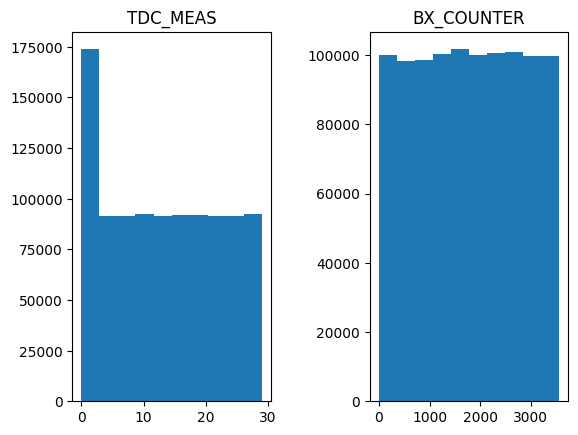

In [87]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)
plt.subplots_adjust(wspace= 0.5)
axs[0].hist(df['TDC_MEAS'])
axs[0].set_title('TDC_MEAS')
axs[1].hist(df['BX_COUNTER'])
axs[1].set_title('BX_COUNTER')
tcd_min, tcd_max = df['TDC_MEAS'].min(), df['TDC_MEAS'].max()
print(tcd_min, tcd_max)

bx_counter_min, bx_counter_max = df['BX_COUNTER'].min(), df['BX_COUNTER'].max()
print(bx_counter_min, bx_counter_max)

Summary: TCD_MEAS resets at 30 and BX counter resests at 3563: there are $x = 3564$ BX_COUNTER units in a ORBIT_CNT

**ORBIT_CNT::BX_COUNTER::TCD_MEAS**
**[0, ..]::[0, 3563]::[0, 29]**

### Request 3

Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [88]:
#df['ORBIT_CNT'].hist(bins = 10)
orbs_count_min = np.min(df['ORBIT_CNT'])
orbs_count_max = np.max(df['ORBIT_CNT'])
num_orbs_counts = orbs_count_max - orbs_count_min + 1
num_orbs_counts

np.int64(8845)

In [89]:
tdc_in_ns = 25./30
bx_in_ns = 25
# Check:
#print(tdc_in_seconds * (tcd_max+ 1), bx_in_seconds)  perfect, it agrees

orbs_in_ns = bx_in_ns * (bx_counter_max + 1)
#print(orbs_count_in_seconds)
subset_total_time = num_orbs_counts * orbs_in_ns
total_time = (subset_total_time/ N) * nrows

print("Total measurement time (estimated):", total_time, " ns")

Total measurement time (estimated): 1032960728.9925001  ns


#### 4\.

Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [90]:
df['time_ns'] = (df['ORBIT_CNT'] - orbs_count_min) * orbs_in_ns + df['BX_COUNTER'] * bx_in_ns + df['TDC_MEAS'] * tdc_in_ns
#df.head()

#### 5\. 
Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [91]:
import numpy.random as npr
df['HEAD'] = npr.choice([0, 1], size= len(df))
#df.head()

#### 6\.
Create a new DataFrame that contains only the rows with HEAD=1.

In [92]:
df_filtered = df[df["HEAD"] == 1].reset_index(drop= True)#.copy()  it is superfluous
print(df_filtered.head())

   HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS       time_ns
0     1     0          123  3869200167        2374        26  59371.666667
1     1     0          124  3869200167        2374        27  59372.500000
2     1     0           64  3869200167        2558        19  63965.833333
3     1     0           63  3869200167        2762         4  69053.333333
4     1     0           61  3869200167        2772        14  69311.666667


#### 7\.
Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

Text(0.5, 1.0, 'Occupacy Plot')

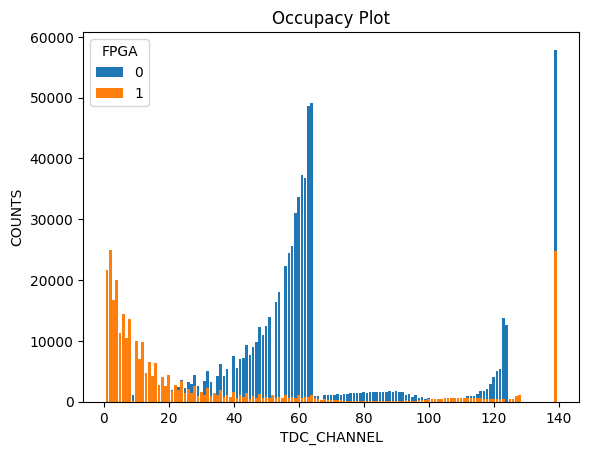

In [ ]:
df_ = df[['FPGA', 'TDC_CHANNEL']].copy()
df_['COUNTS'] = pd.Series(np.ones(len(df)))
result = df_.groupby(['FPGA', 'TDC_CHANNEL']).count()
result_flattened = result.reset_index()

fig, ax = plt.subplots()

for fpga in np.unique(result_flattened['FPGA']):
    temp_df = result_flattened[result_flattened['FPGA'] == fpga]
    x, y = temp_df['TDC_CHANNEL'].values, temp_df['COUNTS'].values
    ax.bar(x, y, label = fpga)

ax.legend(title= "FPGA")
ax.set_xlabel('TDC_CHANNEL')
ax.set_ylabel('COUNTS')
ax.set_title("Occupacy Plot")
